In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import itertools 
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import register_performance_metric, rolling_mean_by_h
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('timeforecast/daily-minimum-temperatures-in-me.csv', parse_dates=['Date'])
df.head()

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 57.2+ KB


In [4]:
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].map(
    lambda x: float(re.sub(r'[^0-9.-]', '', str(x)))
)
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].astype(float)

In [5]:
df.rename(columns={"Date": "ds", "Daily minimum temperatures" : "y"}, inplace=True)

In [6]:
df.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3650 non-null   datetime64[ns]
 1   y       3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing


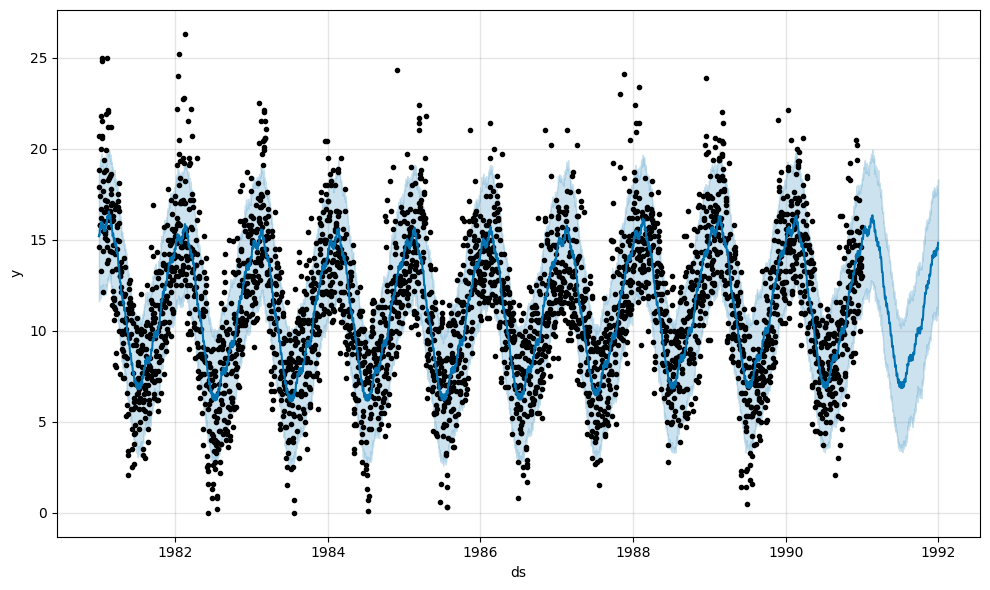

In [8]:
m = Prophet().fit(df)
future = m.make_future_dataframe(periods = 365, freq = 'D')
fcst = m.predict(future)
fig = m.plot(fcst)

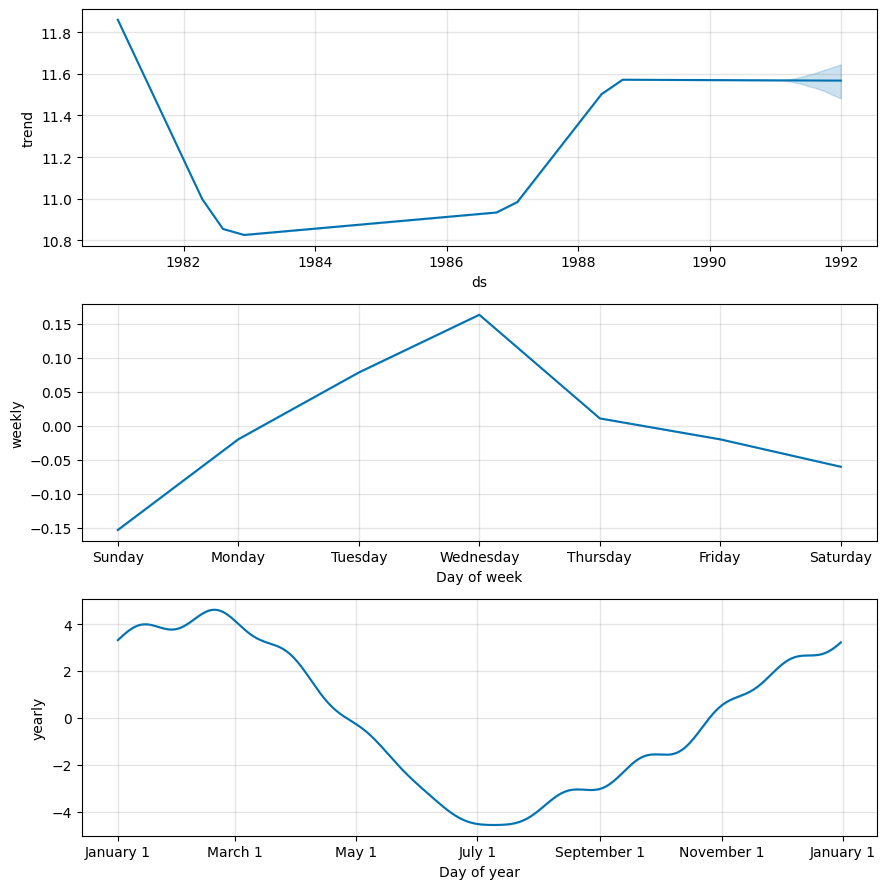

In [9]:
fig = m.plot_components(fcst)

In [10]:
cutoffs = pd.to_datetime(['1990-11-05'])
m_cv = cross_validation(m, cutoffs=cutoffs, horizon = '56 days')
m_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1990-11-06,12.426199,8.888981,15.695247,18.3,1990-11-05
1,1990-11-07,12.523769,8.847817,15.994850,19.2,1990-11-05
2,1990-11-08,12.436983,8.967504,15.589044,15.4,1990-11-05
3,1990-11-09,12.469147,8.999217,16.142430,13.1,1990-11-05
4,1990-11-10,12.486207,8.949778,15.872208,11.5,1990-11-05


In [11]:
m_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
51,1990-12-27,14.622872,11.265035,17.919854,14.0,1990-11-05
52,1990-12-28,14.673308,10.919917,18.079335,13.6,1990-11-05
53,1990-12-29,14.713282,11.060920,18.098721,13.5,1990-11-05
54,1990-12-30,14.683941,11.382353,18.273858,15.7,1990-11-05
55,1990-12-31,14.898120,11.475828,18.285723,13.0,1990-11-05


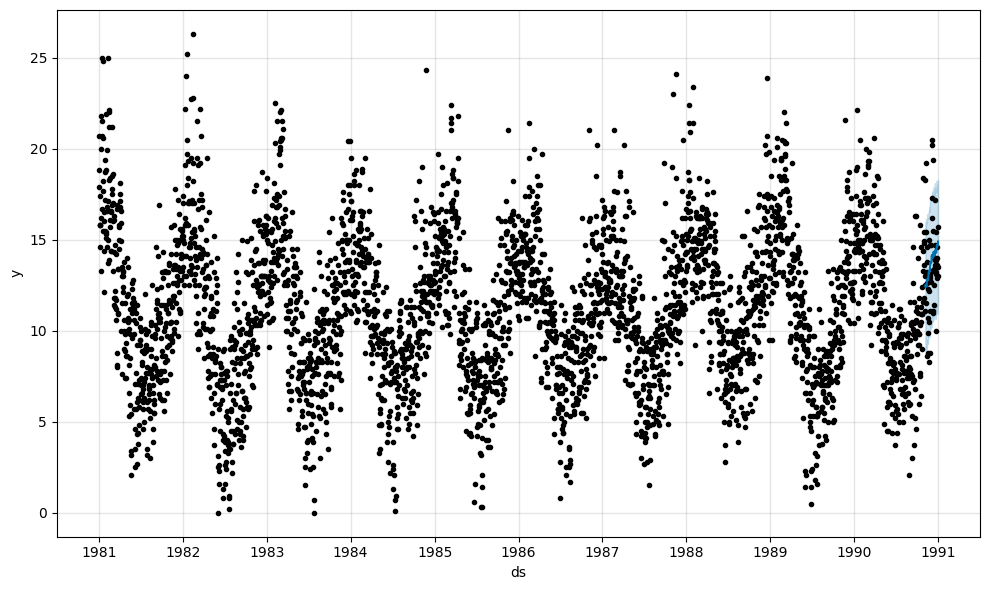

In [12]:
fig = m.plot(m_cv)

In [13]:
mpp = performance_metrics(m_cv)
mpp.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,17.844728,4.224302,3.426022,0.199002,0.192404,0.229538,0.6
1,6 days,13.879526,3.725524,3.017434,0.223897,0.192404,0.225933,0.6
2,7 days,4.965177,2.228268,1.685708,0.154633,0.085757,0.142033,0.8
3,8 days,3.433108,1.852865,1.304682,0.131484,0.076658,0.115399,0.8
4,9 days,3.974670,1.993657,1.530976,0.145994,0.085757,0.131222,0.8


In [14]:
mpp.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
47,52 days,4.674090,2.161964,1.452697,0.131337,0.044491,0.113133,0.8
48,53 days,4.875450,2.208042,1.591150,0.141638,0.078920,0.122909,0.8
49,54 days,1.178939,1.085790,0.940395,0.070272,0.078920,0.067081,1.0
50,55 days,0.810778,0.900432,0.804597,0.056935,0.064717,0.055798,1.0
51,56 days,1.529449,1.236709,1.164728,0.084802,0.078920,0.081682,1.0


In [15]:
@register_performance_metric
def mase(df, w):
    e = (df['y'] - df['yhat'])
    d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
    se = np.abs(e/d)
    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'mase' : se})
    return rolling_mean_by_h(
        x=se.values, h=df['horizon'].values, w=w, name='mase'
    )
    
df_mase = performance_metrics(m_cv, metrics = ['mase'])
df_mase = df_mase.drop(['horizon'], axis = 1).groupby('mase').mean().reset_index()
df_mase.head()

,mase
0,0.403013
1,0.429223
2,0.429314
3,0.438160
4,0.501666


In [16]:
df_mase.tail()

,mase
47,1.827655
48,1.974522
49,2.056712
50,2.392583
51,2.483410


c:\Users\HP\OneDrive\Documents\EXP2\exp2\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\HP\OneDrive\Documents\EXP2\exp2\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


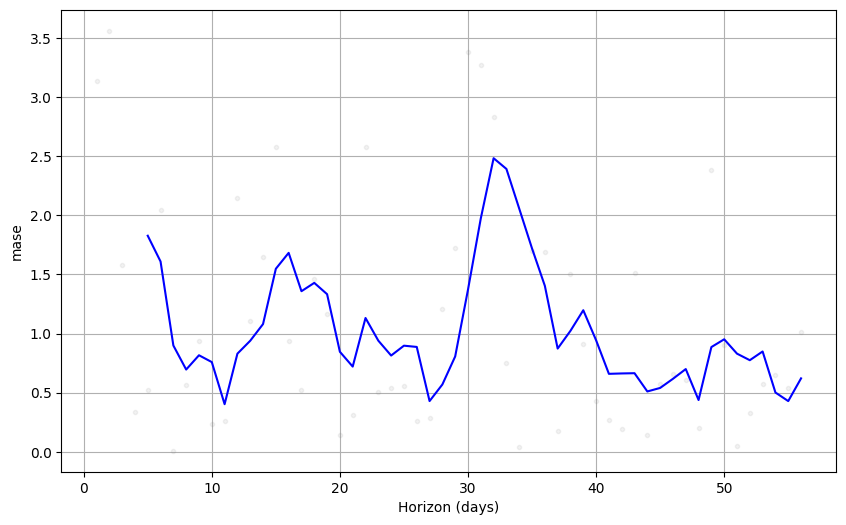

In [17]:
fig = plot_cross_validation_metric(m_cv, metric='mase')